In [ ]:
# use deepmreye environment (python 3.9)
# pip install deepmreye 

In [1]:
# Import modules and add library to path
import sys

sys.path.insert(0,"/Users/sinakling/projects/DeepMReye")
import os

os.environ[
    "CUDA_VISIBLE_DEVICES"] = ""  # Change to os.environ["CUDA_VISIBLE_DEVICES"] = "" if you dont have access to a GPU
import pickle

import numpy as np
import pandas as pd
# Initialize plotly figures
from plotly.offline import init_notebook_mode

# DeepMReye imports
from deepmreye import analyse, preprocess, train
from deepmreye.util import data_generator, model_opts

init_notebook_mode(connected=True)

# Make sure the output width is adjusted for better export as HTML
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:70% !important; }</style>"))
display(HTML("<style>.output_result { max-width:70% !important; }</style>"))

# Autoreload modules
%load_ext autoreload
%autoreload 2

/var/folders/v8/zmb9hj_97tjcq8mb570v8wq40000gp/T/ipykernel_26615/3227686564.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


/var/folders/v8/zmb9hj_97tjcq8mb570v8wq40000gp/T/ipykernel_26615/3227686564.py:23: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [2]:
# Define paths to functional data
experiment_folder = os.getcwd()
print(experiment_folder)
functional_data = os.path.join(experiment_folder, "functional_data")
processed_data = os.path.join(experiment_folder, "processed_data/")
model_weights = os.path.join(experiment_folder, "model_weights",
                             "datasets_1to6.h5")

# Create processed data folder if necessary
if not os.path.exists(processed_data):
    os.makedirs(processed_data)

# Get participants from functional folder
# (if needed, remove single participants with participants.remove('participant01') or recreate participants list)
participants = os.listdir(functional_data)

/Users/sinakling/projects/DeepMReye/closed_data


In [135]:
# Preload masks to save time within participant loop
(
    eyemask_small,
    eyemask_big,
    dme_template,
    mask,
    x_edges,
    y_edges,
    z_edges,
) = preprocess.get_masks()

# Loop across participants and extract eye mask
for participant in participants:

    if participant.startswith("s"):

        print(f"Running participant {participant}")
        participant_folder = os.path.join(functional_data, participant)

        for run in os.listdir(participant_folder):

            if run.startswith("sub"):

                # Filepath to functional
                fp_func = os.path.join(participant_folder, run)

                preprocess.run_participant(fp_func, dme_template, eyemask_big, eyemask_small, x_edges, y_edges, z_edges, transforms=['Affine', 'Affine', 'SyNAggro'])

                #preprocess.run_participant(
                #    fp_func,
                #    dme_template,
                #    eyemask_big,
                #    eyemask_small,
                #    x_edges,
                #    y_edges,
                #    z_edges,
                #)

Running participant sub-01
Mask 0/2, Sum: -37.200, Mean -3.100, Std 8.057, Median 0.003
Mask 1/2, Sum: 12.612, Mean 1.051, Std 6.375, Median 0.025
Mask 2/2, Sum: -5.561, Mean -0.463, Std 5.508, Median 0.054
Mask 0/2, Sum: -37.575, Mean -3.131, Std 8.118, Median -0.003


KeyboardInterrupt: 

In [40]:
print(participant_folder)

/Users/sinakling/projects/DeepMReye/calib_data/functional_data/sub-02


In [42]:
# Combine processed masks with labels
for participant in participants:

    if participant.startswith("s"):

        print(f"Running participant {participant}")
        participant_folder = os.path.join(functional_data, participant)

        participant_data, participant_labels, participant_ids = [], [], []

        for run_idx, run in enumerate(os.listdir(participant_folder)):
            

            if not run.endswith(".p"):
                continue

            # Load mask and normalize it
            this_mask = os.path.join(participant_folder, run)
            this_mask = pickle.load(open(this_mask, "rb"))
            this_mask = preprocess.normalize_img(this_mask)

            # If experiment has no labels use dummy labels
            this_label = np.zeros(
                (this_mask.shape[3], 10, 2)
            )  # 10 is the number of subTRs used in the pretrained weights, 2 is XY

            # Check if each functional image has a corresponding label.
            # Note that mask has time as third dimension
            if this_mask.shape[3] != this_label.shape[0]:
                print(
                    f"WARNING --- Skipping Subject {participant} Run {run_idx} "
                    f"--- Wrong alignment (Mask {this_mask.shape} - Label {this_label.shape})."
                )

                continue

            # Store across runs
            participant_data.append(this_mask)  # adds data per run to list
            participant_labels.append(this_label)
            participant_ids.append(([participant] * this_label.shape[0],
                                    [run_idx] * this_label.shape[0]))
            

        # Save participant file
        preprocess.save_data(
            f"{participant}no_label",
            participant_data,
            participant_labels,
            participant_ids,
            processed_data,
            center_labels=False,
        )

Running participant sub-01


/Users/sinakling/projects/DeepMReye/deepmreye/preprocess.py:546: RuntimeWarning:

Mean of empty slice

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning:

Degrees of freedom <= 0 for slice.



Saving eye data (462, 47, 29, 18) and targets (462, 10, 2) (NaN 0) to file /Users/sinakling/projects/DeepMReye/calib_data/processed_data/sub-01no_label
Running participant sub-02
Saving eye data (462, 47, 29, 18) and targets (462, 10, 2) (NaN 0) to file /Users/sinakling/projects/DeepMReye/calib_data/processed_data/sub-02no_label


In [6]:
# Define paths to dataset
datasets = [
    processed_data + p for p in os.listdir(processed_data) if "no_label" in p
]

# Load data from one participant to showcase input/output
X, y = data_generator.get_all_subject_data(datasets[0])
print(f"Input: {X.shape}, Output: {y.shape}")

Input: (462, 47, 29, 18, 1), Output: (462, 10, 2)


In [ ]:
fig = analyse.visualise_input_data(X,
                                   y,
                                   bg_color="rgb(255,255,255)",
                                   ylim=[-11, 11])
fig.show()

In [8]:
opts = model_opts.get_opts()
test_participants = [
    processed_data + p for p in os.listdir(processed_data) if "no_label" in p
]
generators = data_generator.create_generators(test_participants,
                                              test_participants)
generators = (*generators, test_participants, test_participants
              )  # Add participant list

Training set (/Users/sinakling/projects/DeepMReye/calib_data/processed_data) contains 2 subjects: 
['sub-01no_label', 'sub-02no_label']
Test set (/Users/sinakling/projects/DeepMReye/calib_data/processed_data) contains 2 subjects: 
['sub-01no_label', 'sub-02no_label']


In [9]:
# Get untrained model and load with trained weights
(model, model_inference) = train.train_model(dataset="calib_data",
                                             generators=generators,
                                             opts=opts,
                                             return_untrained=True)
model_inference.load_weights(model_weights)

In [27]:
(evaluation, scores) = train.evaluate_model(
    dataset="calib_data",
    model=model_inference,
    generators=generators,
    save=False,
    model_path=experiment_folder,
    model_description="",
    verbose=2,
    percentile_cut=80,
)

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

1 / 2 - Model Performance for /Users/sinakling/projects/DeepMReye/calib_data/processed_data/sub-01no_label.npz
              Pearson          R^2-Score             Eucl. Error             
                    X   Y Mean         X     Y  Mean        Mean Median   Std
Default           NaN NaN  NaN     0.000 0.000 0.000       3.808  4.067 2.227
Default subTR     NaN NaN  NaN     0.000 0.000 0.000       3.795  4.026 2.225
Refined           NaN NaN  NaN     0.000 0.000 0.000       3.871  4.151 2.321
Refined subTR     NaN NaN  NaN     0.000 0.000 0.000       3.897  4.130 2.313


2 / 2 - Model Performance for /Users/sinakling/projects/DeepMReye/calib_data/processed_data/sub-02no_label.npz
              Pearson          R^2-Score             Eucl. Error             
                    X   Y Mean         X     Y  Mean        Mean Median   Std
Default           NaN NaN  NaN     0.000 0.000 0.000       3.294  3.678 1.754
Default subTR     NaN NaN  NaN     0.000 0.000 0.000       3.268  3.624 1.

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/sinakling/softwares/anaconda3/envs/deepmreye/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

In [ ]:
def adapt_evaluation(participant_evaluation):
    pred_y = participant_evaluation["pred_y"]
    pred_y_median = np.nanmedian(pred_y, axis=1)
    pred_uncertainty = abs(participant_evaluation["euc_pred"])
    pred_uncertainty_median = np.nanmedian(pred_uncertainty, axis=1)
    df_pred_median = pd.DataFrame(
        np.concatenate(
            (pred_y_median, pred_uncertainty_median[..., np.newaxis]), axis=1),
        columns=["X", "Y", "Uncertainty"],
    )
    # With subTR
    subtr_values = np.concatenate((pred_y, pred_uncertainty[..., np.newaxis]),
                                  axis=2)
    index = pd.MultiIndex.from_product(
        [range(subtr_values.shape[0]),
         range(subtr_values.shape[1])],
        names=["TR", "subTR"])
    df_pred_subtr = pd.DataFrame(subtr_values.reshape(-1,
                                                      subtr_values.shape[-1]),
                                 index=index,
                                 columns=["X", "Y", "pred_error"])

    return df_pred_median, df_pred_subtr

In [ ]:
df_pred_median, df_pred_subtr = adapt_evaluation(evaluation[list(
            evaluation.keys())[0]])

In [ ]:
# extract runs from sub TR resolution prediction

pred_sub_01_run_01_X = np.array(df_pred_subtr['X'][:1540])
pred_sub_01_run_02_X = np.array(df_pred_subtr['X'][1540:3080])
pred_sub_01_run_03_X = np.array(df_pred_subtr['X'][3080:])

pred_sub_01_run_01_Y = np.array(df_pred_subtr['Y'][:1540])
pred_sub_01_run_02_Y = np.array(df_pred_subtr['Y'][1540:3080])
pred_sub_01_run_03_Y = np.array(df_pred_subtr['Y'][3080:])

In [4]:
subject = 'sub-01'

In [5]:
expected_x_run_1 = np.load(f'expected_x_data_Closed_{subject}_run_1.npy')
expected_y_run_1 = np.load(f'expected_y_data_Closed_{subject}_run_1.npy')

expected_x_run_2 = np.load(f'expected_x_data_Closed_{subject}_run_2.npy')
expected_y_run_2 = np.load(f'expected_y_data_Closed_{subject}_run_2.npy')

expected_x_run_3 = np.load(f'expected_x_data_Closed_{subject}_run_3.npy')
expected_y_run_3 = np.load(f'expected_y_data_Closed_{subject}_run_3.npy')


expected_x_all_runs = [expected_x_run_1,expected_x_run_2,expected_x_run_3]
expected_y_all_runs = [expected_y_run_1,expected_y_run_2,expected_y_run_3]

In [5]:
eyetracking_x_run_1 = np.load(f'/Users/sinakling/projects/DeepMReye/closed_data/eyetracking_x_data_Closed_{subject}_run_1.npy')
eyetracking_x_run_2 = np.load(f'/Users/sinakling/projects/DeepMReye/closed_data/eyetracking_x_data_Closed_{subject}_run_2.npy')
eyetracking_x_run_3 = np.load(f'/Users/sinakling/projects/DeepMReye/closed_data/eyetracking_x_data_Closed_{subject}_run_3.npy')

eyetracking_all_runs_X = [eyetracking_x_run_1,eyetracking_x_run_2,eyetracking_x_run_3]

eyetracking_y_run_1 = np.load(f'/Users/sinakling/projects/DeepMReye/closed_data/eyetracking_y_data_Closed_{subject}_run_1.npy')
eyetracking_y_run_2 = np.load(f'/Users/sinakling/projects/DeepMReye/closed_data/eyetracking_y_data_Closed_{subject}_run_2.npy')
eyetracking_y_run_3 = np.load(f'/Users/sinakling/projects/DeepMReye/closed_data/eyetracking_y_data_Closed_{subject}_run_3.npy')

eyetracking_all_runs_Y = [eyetracking_y_run_1,eyetracking_y_run_2,eyetracking_y_run_3]

In [7]:
pred_sub_01_01_intpl_X = np.interp(
    np.linspace(0, 1, len(eyetracking_x_run_1)),
    np.linspace(0, 1, len(pred_sub_01_run_01_X)),
    pred_sub_01_run_01_X
)

pred_sub_01_02_intpl_X = np.interp(
    np.linspace(0, 1, len(eyetracking_x_run_2)),
    np.linspace(0, 1, len(pred_sub_01_run_02_X)),
    pred_sub_01_run_02_X
)

pred_sub_01_03_intpl_X = np.interp(
    np.linspace(0, 1, len(eyetracking_x_run_3)),
    np.linspace(0, 1, len(pred_sub_01_run_03_X)),
    pred_sub_01_run_03_X
)

predicted_all_runs_X = [pred_sub_01_01_intpl_X,pred_sub_01_02_intpl_X,pred_sub_01_03_intpl_X]

np.save("closed_deepmreye_X_sub-01_run_01", predicted_all_runs_X[0])
np.save("closed_deepmreye_X_sub-01_run_02", predicted_all_runs_X[1])
np.save("closed_deepmreye_X_sub-01_run_03", predicted_all_runs_X[2])

pred_sub_01_01_intpl_Y = np.interp(
    np.linspace(0, 1, len(eyetracking_y_run_1)),
    np.linspace(0, 1, len(pred_sub_01_run_01_Y)),
    -1.0*(strl_sub_01_01['Y'])                   # Invert because of PsychToolBox coordinates
)

pred_sub_01_02_intpl_Y = np.interp(
    np.linspace(0, 1, len(eyetracking_y_run_2)),
    np.linspace(0, 1, len(pred_sub_01_run_02_Y)),
    -1.0*(pred_sub_01_run_02_Y)
)

pred_sub_01_03_intpl_Y = np.interp(
    np.linspace(0, 1, len(eyetracking_y_run_3)),
    np.linspace(0, 1, len(pred_sub_01_run_03_Y)),
    -1.0*(pred_sub_01_run_03_Y)
)

predicted_all_runs_Y = [pred_sub_01_01_intpl_Y,pred_sub_01_02_intpl_Y,pred_sub_01_03_intpl_Y]

np.save("closed_deepmreye_Y_sub-01_run_01", predicted_all_runs_Y[0])
np.save("closed_deepmreye_Y_sub-01_run_02", predicted_all_runs_Y[1])
np.save("closed_deepmreye_Y_sub-01_run_03", predicted_all_runs_Y[2])

In [56]:
def min_max_scale(data): 
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

    return (data - min_val) / (max_val - min_val)



In [11]:
import scipy.stats as stats

eyetracking_all_runs_X_scaled = []

for elem in eyetracking_all_runs_X: 
    elem_scaled = stats.zscore(elem,nan_policy='omit')
    eyetracking_all_runs_X_scaled.append(elem_scaled)


expected_all_runs_X_scaled = []

for elem in expected_x_all_runs: 
    elem_scaled = stats.zscore(elem,nan_policy='omit')
    expected_all_runs_X_scaled.append(elem_scaled)


predicted_all_runs_X_scaled = []

for elem in predicted_all_runs_X: 
    elem_scaled = stats.zscore(elem,nan_policy='omit')
    predicted_all_runs_X_scaled.append(elem_scaled)


eyetracking_all_runs_Y_scaled = []

for elem in eyetracking_all_runs_Y: 
    elem_scaled = stats.zscore(elem,nan_policy='omit')
    eyetracking_all_runs_Y_scaled.append(elem_scaled)


expected_all_runs_Y_scaled = []

for elem in expected_y_all_runs: 
    elem_scaled = stats.zscore(elem,nan_policy='omit')
    expected_all_runs_Y_scaled.append(elem_scaled)


predicted_all_runs_Y_scaled = []

for elem in predicted_all_runs_Y: 
    elem_scaled = stats.zscore(elem,nan_policy='omit')
    predicted_all_runs_Y_scaled.append(elem_scaled)   

In [10]:
# create dataframe 
# remove instructions time from beginning and end to make all same length
def trim_lists_to_shortest(input_lists):
    # Find the length of the shortest list
    min_length = min(len(lst) for lst in input_lists)

    # Trim each list to the length of the shortest one
    trimmed_lists = [lst[:min_length] for lst in input_lists]

    return trimmed_lists

In [9]:
eyetracking_data_all_runs_x_trim = trim_lists_to_shortest(eyetracking_all_runs_X_scaled)
eyetracking_data_all_runs_y_trim = trim_lists_to_shortest(eyetracking_all_runs_Y_scaled)

for i in eyetracking_data_all_runs_x_trim: 
    print(len(i))


for i in eyetracking_data_all_runs_y_trim: 
    print(len(i))


data = {"run_01_x": list(eyetracking_data_all_runs_x_trim[0]), "run_01_y": list(eyetracking_data_all_runs_y_trim[0]), "run_02_x": list(eyetracking_data_all_runs_x_trim[1]), "run_02_y": list(eyetracking_data_all_runs_y_trim[1]), "run_03_x": list(eyetracking_data_all_runs_x_trim[2]), "run_03_y": list(eyetracking_data_all_runs_y_trim[2])}

df = pd.DataFrame(data)
df

NameError: name 'eyetracking_all_runs_X_scaled' is not defined

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

time_ticks_val = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000, 320000, 340000, 360000, 380000]
time_ticks_text = ['0', '20', "40", "60","80", "100", "120", "140", "160", "180","200", "220", "240", "260", "280","300", "320", "340", "360", "380"]

dva_ticks_val = [np.min(expected_all_runs_X_scaled[0]),0,np.max(expected_all_runs_X_scaled[0])]
dva_ticks_txt = ['-9', '0', '9']

plot_rows = 3
plot_cols = 2

fig = make_subplots(rows=plot_rows, cols=plot_cols,shared_xaxes=True,vertical_spacing=0.05, subplot_titles= ['Hor. Coord. run 1', 'Ver. Coord. run 1', 'Hor. Coord. run 2', 'Ver. Coord. run 2', 'Hor. Coord. run 3', 'Ver. Coord. run 3'])

# Set a common y-axis range
common_y_range = [-2.6,2.6]  # Adjust the range as needed

# add traces
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        trace = go.Scatter(x=df.index, y=df[df.columns[x]].values,
                           name="Scanner Eyetracker",
                           mode='lines',
                           showlegend = True,
                           line=dict(color='#0E1C36', width=1.5))

        fig.add_trace(trace, row=i, col=j)

        # Set common Y-axis range
        fig.update_yaxes(range=common_y_range, row=i, col=j)

        x += 1


fig.add_trace(go.Scatter(y= expected_all_runs_X_scaled[0],showlegend=True, name='Expected',opacity=0.6,line=dict(color='#069D6B', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(y= expected_all_runs_Y_scaled[0],showlegend=False, opacity=0.6, line=dict(color='#069D6B', width=2)), row = 1, col = 2)
fig.add_trace(go.Scatter(y= expected_all_runs_X_scaled[1],showlegend=False,opacity=0.6, line=dict(color='#069D6B', width=2)), row = 2, col = 1)
fig.add_trace(go.Scatter(y= expected_all_runs_Y_scaled[1],showlegend=False,opacity=0.6,line=dict(color='#069D6B', width=2)), row = 2, col = 2)
fig.add_trace(go.Scatter(y= expected_all_runs_X_scaled[2],showlegend=False,opacity=0.6, line=dict(color='#069D6B', width=2)), row = 3, col = 1)
fig.add_trace(go.Scatter(y= expected_all_runs_Y_scaled[2],showlegend=False,opacity=0.6,line=dict(color='#069D6B', width=2)), row = 3, col = 2)

# add predicted traces
fig.add_trace(go.Scatter(y= predicted_all_runs_X_scaled[0],showlegend=True, name='DeepMReye Untrained',line=dict(color='#6FA725', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(y= predicted_all_runs_Y_scaled[0],showlegend=False, line=dict(color='#6FA725', width=2)), row = 1, col = 2)
fig.add_trace(go.Scatter(y= predicted_all_runs_X_scaled[1],showlegend=False,line=dict(color='#6FA725', width=2)), row = 2, col = 1)
fig.add_trace(go.Scatter(y= predicted_all_runs_Y_scaled[1],showlegend=False,line=dict(color='#6FA725', width=2)), row = 2, col = 2)
fig.add_trace(go.Scatter(y= predicted_all_runs_X_scaled[2],showlegend=False,line=dict(color='#6FA725', width=2)), row = 3, col = 1)
fig.add_trace(go.Scatter(y= predicted_all_runs_Y_scaled[2],showlegend=False,line=dict(color='#6FA725', width=2)), row = 3, col = 2)


fig.add_vrect(x0="6000", x1="90000", 
            label=dict(
            text="eyes open",
            textposition="top center"),
            fillcolor="#DCDCE5", opacity=0.2, line_width=0)

fig.add_vrect(x0="98000", x1="182000", 
            label=dict(
            text="eyes part. closed",
            textposition="top center"),
            fillcolor="#D8DDEF", opacity=0.2, line_width=0)

fig.add_vrect(x0="190000", x1="273500", 
            label=dict(
            text="no stim.",
            textposition="top center"),
            fillcolor="#A0A4B8", opacity=0.1, line_width=0)

fig.add_vrect(x0="284000", x1="366000", 
            label=dict(
            text="eyes closed",
            textposition="top center"),
            fillcolor="#7293A0", opacity=0.1, line_width=0)

#Format and show fig
fig.update_layout(height=1200, width=3000, template="simple_white", title_text=f"{subject} Scanner Eyetracker vs. DeepMReye Untrained vs. Expected Gaze Position", 
            yaxis1 = dict(title = "<b>Hor. coord. (dva)<b>", title_font=dict(size=12), tickmode = 'array', tickvals = dva_ticks_val, ticktext = dva_ticks_txt),
            yaxis2 = dict(title = "<b>Ver. coord. (dva)<b>",title_font=dict(size=12),tickmode = 'array', tickvals = dva_ticks_val, ticktext = dva_ticks_txt),
            yaxis3 = dict(title = "<b>Hor. coord. (dva)<b>",title_font=dict(size=12),tickmode = 'array', tickvals = dva_ticks_val, ticktext = dva_ticks_txt),
            yaxis4 = dict(title = "<b>Ver. coord. (dva)<b>",title_font=dict(size=12),tickmode = 'array', tickvals = dva_ticks_val, ticktext = dva_ticks_txt),
            xaxis5=dict(title='<b>Time (sec)<b>', tickmode = 'array', tickvals = time_ticks_val, ticktext = time_ticks_text),
            yaxis5 = dict(title = "<b>Hor. coord. (dva)<b>", title_font=dict(size=12),tickmode = 'array', tickvals = dva_ticks_val, ticktext = dva_ticks_txt),
            xaxis6=dict(title='<b>Time (sec)<b>', tickmode = 'array', tickvals = time_ticks_val, ticktext = time_ticks_text),
            yaxis6 = dict(title = "<b>Ver. coord. (dva)<b>",tickmode = 'array', tickvals = dva_ticks_val, ticktext = dva_ticks_txt))

# Update the legend to be not visible for specifc traces
fig.update_traces(showlegend= True, row = 1, col = 1, selector=dict(name= "DeepMReyeClosed Eyetracker Gaze Position"))
fig.update_traces(showlegend=False, row=1, col=2)
fig.update_traces(showlegend=False, row=2, col=1)
fig.update_traces(showlegend=False, row=2, col=2)
fig.update_traces(showlegend=False, row=3, col=1)
fig.update_traces(showlegend=False, row=3, col=2)

# Update subplot titles font
fig.update_annotations(font=dict(size=14))


fig.show()
#fig.write_image(f'{subject}_closed_scanner_gazeposition_eyetracker.pdf')


In [13]:
# Average gaze position 

eyetracking_data_avg_x = (np.array(eyetracking_data_all_runs_x_trim[0]) + np.array(eyetracking_data_all_runs_x_trim[1])) / 2
eyetracking_data_avg_y = (np.array(eyetracking_data_all_runs_y_trim[0]) + np.array(eyetracking_data_all_runs_y_trim[1])) / 2

In [29]:
expected_position_x = [-9.0,9.0,0.0,-9.0,9.0]
expected_position_y = [9.0,9.0,0.0,-9.0,-9.0]


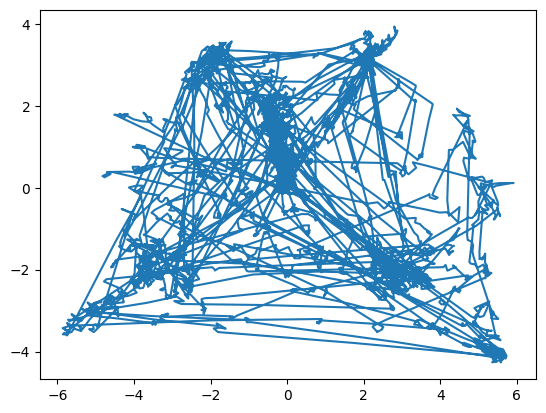

In [12]:
import matplotlib.pyplot as plt

predicted_data_all_runs_x_trim = trim_lists_to_shortest(predicted_all_runs_X)
predicted_data_all_runs_y_trim = trim_lists_to_shortest(predicted_all_runs_Y)

avg_pred_X = (predicted_data_all_runs_x_trim[0] + predicted_data_all_runs_x_trim[1] + predicted_data_all_runs_x_trim[2]) / 3
avg_pred_Y = (predicted_data_all_runs_y_trim[0] + predicted_data_all_runs_y_trim[1] + predicted_data_all_runs_y_trim[2]) / 3

#avg_real_X = (eyetracking_data_all_runs_x_trim[0] + eyetracking_data_all_runs_x_trim[1] + eyetracking_data_all_runs_x_trim[2]) / 3
#avg_real_Y = (eyetracking_data_all_runs_y_trim[0] + eyetracking_data_all_runs_y_trim[1] + eyetracking_data_all_runs_y_trim[2]) / 3


plt.plot(avg_pred_X, avg_pred_Y)

In [15]:
trial_durations = np.load("/Users/sinakling/projects/DeepMReye/closed_data/trial_duratations.npy")

In [ ]:
# Plot Difference in Subplot

import plotly.graph_objects as go
from plotly.subplots import make_subplots



plot_rows = 1
plot_cols = 4

fig = make_subplots(rows=plot_rows, cols=plot_cols,shared_xaxes=False,vertical_spacing=0.05, subplot_titles=["Eyes open", "Eyes part. closed", "No stim.", "Eyes closed"])




fig.add_trace(go.Scatter(x = avg_pred_X[:90000] ,y = avg_pred_Y[:90000], line=dict(color='#069D6B', width=2.5),showlegend= False), row = 1, col = 1)
fig.add_trace(go.Scatter(x = avg_pred_X[98000:182000] ,y = avg_pred_Y[98000:182000],line=dict(color='#069D6B', width=2.5),showlegend= False), row = 1, col = 2)
fig.add_trace(go.Scatter(x = avg_pred_X[189000:273000],y = avg_pred_Y[189000:273000],line=dict(color='#069D6B', width=2.5),showlegend= False), row = 1, col = 3)
fig.add_trace(go.Scatter(x = avg_pred_X[283000:366000],y = avg_pred_Y[283000:366000],line=dict(color='#6FA725', width=2.5),showlegend= False), row = 1, col = 4)

#fig.add_trace(go.Scatter(x = expected_position_x ,y = expected_position_y, line=dict(color='black', width=1.5),showlegend= False,opacity=0.45), row = 1, col = 1)
#fig.add_trace(go.Scatter(x = expected_position_x ,y = expected_position_y,line=dict(color='black', width=1.5,dash='dashdot'),showlegend= False,opacity=0.45), row = 1, col = 2)
#fig.add_trace(go.Scatter(x = expected_position_x,y = expected_position_y,line=dict(color='black', width=1.5,dash='dashdot'),showlegend= False,opacity=0.45), row = 1, col = 3)


# Format and show fig
fig.update_layout(height=1000, width=2400, template="simple_white", title_text=f"{subject} DeepMReye Average Gaze Position", 
            yaxis1 = dict(title = "Vert. coord. (dva)", range = [-10,10]),
            xaxis1 = dict(title = "Hor. coord. (dva)", range = [-10,10]),
            yaxis2 = dict(title = "Vert. coord. (dva)", range = [-10,10]),
            xaxis2 = dict(title = "Hor. coord. (dva)", range = [-10,10]),
            yaxis3 = dict(title = "Vert. coord. (dva)", range = [-10,10]),
            xaxis3 = dict(title = "Hor. coord. (dva)", range = [-10,10]),
            yaxis4 = dict(title = "Vert. coord. (dva)", range = [-10,10]),
            xaxis4 = dict(title = "Hor. coord. (dva)", range = [-10,10]))


# Update subplot titles font
fig.update_annotations(font=dict(size=14))

fig.update_layout(
    coloraxis_showscale=False,
    autosize=False,
    width=2000,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,


        t=100,
        pad=4
    ))

fig.update_coloraxes(showscale=False)

fig.show()
fig.write_image(f'{subject}_pretrained_gazeposition_closed.pdf')

#colorscale=[[1, 'rgb(255,255,255)'], [0.75, 'rgb(160,164,184)'], [0.5, 'rgb(169,198,184)'], [0.25, 'rgb(216,221,239)'], [0, 'rgb(0,0,0)']]





In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define starting indices for slicing
start_indices = [9, 21, 34, 46, 59, 71, 84, 96] # calculated in data_analysis_closed
# down = [0, 12, 25, 37, 50, 62, 75, 87]

fig = make_subplots(rows=1, cols=4, shared_xaxes=True, subplot_titles=["Eyes Open", "Eyes Blink", "No Stim.", "Eyes Closed"])

# Set a common y-axis range
common_y_range = [-9, 9]  # Adjust the range as needed
common_x_range = [-9, 9]  # Adjust the range as needed

# Define color for all slices
color = '#4DCBA1'

# Iterate over start indices and plot data slices
for i, start_index in enumerate(start_indices):
    end_index = start_index + 3
    x_data = avg_pred_X[int(trial_durations[start_index]):int(trial_durations[end_index])]
    y_data = avg_pred_Y[int(trial_durations[start_index]):int(trial_durations[end_index])]
    
    if i < 2:
        fig.add_trace(go.Scatter(x=x_data, y=y_data, line=dict(color=color, width=2.5), showlegend=False), row=1, col=1)
        fig.update_yaxes(range=common_y_range, row=1, col=1)
        fig.update_xaxes(range=common_x_range, row=1, col=1)
    elif 2 <= i < 4:
        fig.add_trace(go.Scatter(x=x_data, y=y_data, line=dict(color=color, width=2.5), showlegend=False),  row=1, col=2)
        fig.update_yaxes(range=common_y_range, row=1, col=2)
        fig.update_xaxes(range=common_x_range, row=1, col=2)
    elif 4 <= i < 6:
        fig.add_trace(go.Scatter(x=x_data, y=y_data, line=dict(color=color, width=2.5), showlegend=False),  row=1, col=3)
        fig.update_yaxes(range=common_y_range, row=1, col=3)
        fig.update_xaxes(range=common_x_range, row=1, col=3)
    else:
        fig.add_trace(go.Scatter(x=x_data, y=y_data, line=dict(color=color, width=2.5), showlegend=False), row=1, col=4)
        fig.update_yaxes(range=common_y_range, row=1, col=4)
        fig.update_xaxes(range=common_x_range, row=1, col=4)

# Add expected position traces
# fig.add_trace(go.Scatter(x=expected_position_x, y=expected_position_y, line=dict(color='black', width=1.5, dash='dashdot'), name='Expected Position', opacity=0.45))

# Format and show fig
fig.update_layout(height=600, width=2000, template="simple_white", title_text=f"{subject} DeepMReye Pretrained Average Gaze Position Triangle Right", 
            yaxis1 = dict(title = "Vert. coord. (dva)"),
            xaxis1 = dict(title = "Hor. coord. (dva)"),
            yaxis2 = dict(title = "Vert. coord. (dva)"),
            xaxis2 = dict(title = "Hor. coord. (dva)"),
            yaxis3 = dict(title = "Vert. coord. (dva)"),
            xaxis3 = dict(title = "Hor. coord. (dva)"),
            yaxis4 = dict(title = "Vert. coord. (dva)"),
            xaxis4 = dict(title = "Hor. coord. (dva)"))

# Update annotations font
fig.update_annotations(font=dict(size=14))

fig.update_layout(
    coloraxis_showscale=False,
    autosize=False,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

fig.update_coloraxes(showscale=False)

fig.show()
#fig.write_image(f'{subject}_scanner_gazeposition_closed.pdf')


In [ ]:
#fig = analyse.visualise_predictions_slider(evaluation, scores, color="rgb(0, 150, 175)", bg_color="rgb(255,255,255)", ylim=[-11, 11])
fig = analyse.visualise_predictions_click(evaluation, scores, color="rgb(0, 150, 175)", bg_color="rgb(255,255,255)")
fig.show()

In [ ]:
# animated plots, error plots in data_analysis_closed